## Import Libraries

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM
from pylab import rcParams

### Company selection

In [3]:
comp = pd.read_csv('securities.csv')
comp.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


As referred in report, 5 companies in the airline industry are selected: American Airlines Group, Southwest Airlines, United Continental Holdings, Delta Air Lines, and Alaska Air Group Inc. 

In [4]:
##find corresponding symbol for each company in the order A-Z
comp_5 = comp.loc[(comp['Security'] == 'Alaska Air Group Inc') | 
                  (comp['Security'] == 'American Airlines Group') | 
                  (comp['Security'] == 'Delta Air Lines') | 
                  (comp['Security'] == 'Southwest Airlines') | 
                  (comp['Security'] == 'United Continental Holdings'), ['Ticker symbol']]
print(comp_5)


    Ticker symbol
15            ALK
28            AAL
137           DAL
411           LUV
458           UAL


## Read Data

In [5]:
df = pd.read_csv('prices-split-adjusted.csv')

In [6]:
df.head().round(3)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.43,125.84,122.31,126.25,2163600.0
1,2016-01-06,WLTW,125.24,119.98,119.94,125.54,2386400.0
2,2016-01-07,WLTW,116.38,114.95,114.93,119.74,2489500.0
3,2016-01-08,WLTW,115.48,116.62,113.50,117.44,2006300.0
4,2016-01-11,WLTW,117.01,114.97,114.09,117.33,1408600.0


In [7]:
#check the shape of loaded dataset
print(df.shape)

(851264, 7)


### check data quality

Find out if there are missing data:

In [8]:
#there are no missing data. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [9]:
df[df.isnull().any(axis=1)]

,date,symbol,open,close,low,high,volume


In [10]:
#find out unique symbols info
q = df.symbol.unique()
print("number of unique symbols:", len(q))
print("first 10 unique symbols are:", q[0:10])

number of unique symbols: 501
first 10 unique symbols are: ['WLTW' 'A' 'AAL' 'AAP' 'AAPL' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI']


## Visualization of opening and closing stock prices for each company

In [11]:
def visualization(i):
    company_data = df.loc[df['symbol'] == i]
    company_data_open = np.array(company_data['open']).reshape(-1,1)
    company_data_close = np.array(company_data['close']).reshape(-1,1)
    plt.subplot(2, 1, 1)
    ax = df.plot
    plt.plot(company_data_open)
    plt.xlabel('Time')
    plt.ylabel(i + 'opening stock price')
    
    plt.subplot(2, 1, 2)
    plt.plot(company_data_close)
    plt.xlabel('Time')
    plt.ylabel(i + 'closing stock price')
    
    plt.show()

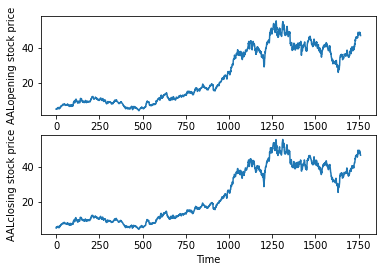

In [12]:
visualization('AAL')

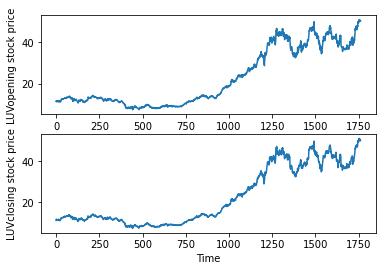

In [13]:
visualization('LUV')

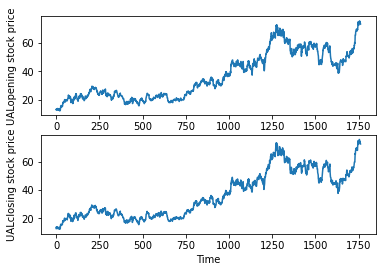

In [14]:
visualization('UAL')

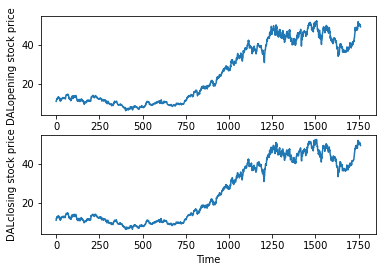

In [15]:
visualization('DAL')

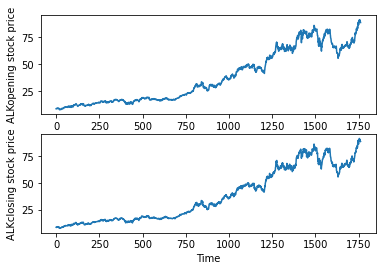

In [16]:
visualization('ALK')

Above plots show that the differences between opening and closing prices are marginal, closing price is selected as explained in the report

To better visualize the stock price over time, adjust the x-axis to date format

In [17]:
df.loc[:,'date']=pd.to_datetime(df['date'],format='%Y-%m-%d')
df['month'] = df['date'].dt.month
df.head()

,date,symbol,open,close,low,high,volume,month
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,1
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,1
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,1
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1


In [18]:
#generate table for each company
ALK = df.loc[df['symbol'] == 'ALK']
AAL = df.loc[df['symbol'] == 'AAL']
DAL = df.loc[df['symbol'] == 'DAL']
LUV = df.loc[df['symbol'] == 'LUV']
UAL = df.loc[df['symbol'] == 'UAL']

In [19]:
#view summary stats for random company
LUV.describe()

,open,close,low,high,volume,month
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03,1762.000000
mean,22.489109,22.489387,22.198649,22.769098,7.711555e+06,6.549943
std,13.780502,13.783337,13.598771,13.954358,3.598728e+06,3.426034
min,7.370000,7.350000,7.150000,7.550000,1.475000e+06,1.000000
25%,11.380000,11.400000,11.230000,11.550000,5.458375e+06,4.000000
50%,13.820000,13.810000,13.690000,13.945000,7.000200e+06,7.000000
75%,37.457499,37.327501,36.777499,37.947501,9.006950e+06,10.000000
max,50.770000,50.889999,50.520000,51.340000,4.382490e+07,12.000000


In [20]:
LUV.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762 entries, 516 to 851045
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1762 non-null   datetime64[ns]
 1   symbol  1762 non-null   object        
 2   open    1762 non-null   float64       
 3   close   1762 non-null   float64       
 4   low     1762 non-null   float64       
 5   high    1762 non-null   float64       
 6   volume  1762 non-null   float64       
 7   month   1762 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 123.9+ KB


## train and test set split

In [21]:
##The price of the previous 50 days is used to predict the price of the next day
#the number of test dataset should add 50
test_size=0.2
num_test = int(test_size*len(df))+50
num_train = len(df) - num_test

##split dataset
train = df[:num_train]
test = df[num_train:]
print("shape of train:",train.shape)
print("shape of test:", test.shape)

shape of train: (680962, 8)
shape of test: (170302, 8)


In [22]:
##create table for each comopany
#AAL
AALtrain = train.loc[train['symbol'] == 'AAL']
AALtest = test.loc[test['symbol'] == 'AAL']
#LUV
LUVtrain = train.loc[train['symbol'] == 'LUV']
LUVtest = test.loc[test['symbol'] == 'LUV']
#UAL
UALtrain = train.loc[train['symbol'] == 'UAL']
UALtest = test.loc[test['symbol'] == 'UAL']
#DAL
DALtrain = train.loc[train['symbol'] == 'DAL']
DALtest = test.loc[test['symbol'] == 'DAL']
#ALK
ALKtrain = train.loc[train['symbol'] == 'ALK']
ALKtest = test.loc[test['symbol'] == 'ALK']

example: plot AAL train dataset close price over time

Text(0, 0.5, 'price')

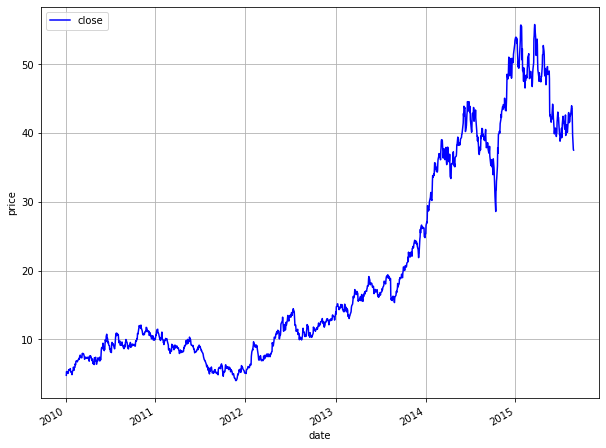

In [23]:
rcParams['figure.figsize']=10, 8
ax=AALtrain.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel('date')
ax.set_ylabel('price')

In [24]:
#view summary stats for random company
LUVtrain.describe()

,open,close,low,high,volume,month
count,1421.000000,1421.000000,1421.000000,1421.000000,1.421000e+03,1421.000000
mean,17.852716,17.847213,17.619986,18.071809,7.910026e+06,6.308234
std,10.987154,10.978176,10.829118,11.122443,3.563757e+06,3.377952
min,7.370000,7.350000,7.150000,7.550000,1.475000e+06,1.000000
25%,10.360000,10.310000,10.240000,10.430000,5.574400e+06,3.000000
50%,12.880000,12.860000,12.720000,13.020000,7.259300e+06,6.000000
75%,23.600000,23.600000,23.280001,23.889999,9.324900e+06,9.000000
max,46.619999,46.990002,46.020000,47.169998,3.628340e+07,12.000000


### Feature Scaling

In [25]:
##normalization
#normalization only on train data ----reason:information leaking
scaler = MinMaxScaler(feature_range=(0, 1))
#choose the close price to make predictions

ALKtrain_data = ALKtrain[['close']].values
ALKtrain_data = scaler.fit_transform(ALKtrain_data)
ALKtest_data = ALKtest[['close']].values
ALKtest_data = scaler.transform(ALKtest_data)

DALtest_data = DALtest[['close']].values
DALtest_data = scaler.transform(DALtest_data)
DALtrain_data = DALtrain[['close']].values
DALtrain_data = scaler.transform(DALtrain_data)

UALtest_data = UALtest[['close']].values
UALtest_data = scaler.transform(UALtest_data)
UALtrain_data = UALtrain[['close']].values
UALtrain_data = scaler.transform(UALtrain_data)

LUVtest_data = LUVtest[['close']].values
LUVtest_data = scaler.transform(LUVtest_data)
LUVtrain_data = LUVtrain[['close']].values
LUVtrain_data = scaler.transform(LUVtrain_data)

AALtest_data = AALtest[['close']].values
AALtest_data = scaler.transform(AALtest_data)
AALtrain_data = AALtrain[['close']].values
AALtrain_data = scaler.transform(AALtrain_data)


## Algorithm 3: LSTM

**Predict ALK close price**

*Convert into timeseries*

In [26]:
ALKtrain_x=[]
ALKtrain_y=[]
for i in range(50,len(ALKtrain_data)):
    ALKtrain_x.append(ALKtrain_data[i-50:i,0])
    ALKtrain_y.append(ALKtrain_data[i,0])
ALKtrain_x=np.array(ALKtrain_x)
ALKtrain_y=np.array(ALKtrain_y)
#reshape data to(samples, features, time stemps)
ALKtrain_x = ALKtrain_x.reshape(ALKtrain_x.shape[0],ALKtrain_x.shape[1],1)

ALKtest_x = []
ALKtest_y = ALKtest_data[50:]
for i in range(50,len(ALKtest_data)):
    ALKtest_x.append(ALKtest_data[i-50:i,0])
ALKtest_x = np.array(ALKtest_x)
#reshape data to(samples, features, time stemps)
ALKtest_x = ALKtest_x.reshape(ALKtest_x.shape[0],ALKtest_x.shape[1],1)

*Define LSTM model*

In [27]:
model = Sequential()
#80 LSTM units
model.add(LSTM(80,input_shape=(ALKtrain_x.shape[1],1), return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=False))
#add Dense layer, output 1 dimension
model.add(Dense(1))
#evaluating based on mean square error (mse), use adadelta to optimize
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 80)            26240     
_________________________________________________________________
dropout (Dropout)            (None, 50, 80)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 77,841
Trainable params: 77,841
Non-trainable params: 0
_________________________________________________________________


*Train model*

In [28]:
%%time
#10-fold cross validation 
#batch_size=20, epochs=50
model.fit(ALKtrain_x, ALKtrain_y,validation_split=0.1,batch_size=20, epochs=50)

Epoch 1/50
62/62 [==============================] - 4s 67ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 2/50
62/62 [==============================] - 3s 45ms/step - loss: 4.0410e-04 - val_loss: 0.0013
Epoch 3/50
62/62 [==============================] - 3s 44ms/step - loss: 3.8856e-04 - val_loss: 0.0013
Epoch 4/50
62/62 [==============================] - 3s 44ms/step - loss: 3.9895e-04 - val_loss: 0.0012
Epoch 5/50
62/62 [==============================] - 3s 44ms/step - loss: 4.6742e-04 - val_loss: 0.0014
Epoch 6/50
62/62 [==============================] - 3s 46ms/step - loss: 3.7084e-04 - val_loss: 0.0011e
Epoch 7/50
62/62 [==============================] - 3s 46ms/step - loss: 3.5535e-04 - val_loss: 0.0013
Epoch 8/50
62/62 [==============================] - 3s 49ms/step - loss: 3.4393e-04 - val_loss: 0.0011
Epoch 9/50
62/62 [==============================] - 3s 47ms/step - loss: 4.5199e-04 - val_loss: 0.0012
Epoch 10/50
62/62 [==============================] - 3s 46ms/step - loss: 3.

*Predict*

In [29]:
%time ALK_predict = model.predict(ALKtest_x) 
#denormalize
ALK_predict = scaler.inverse_transform(ALK_predict)
#mse on train dataset and test dataset
ALK_train_mse = model.evaluate(ALKtrain_x, ALKtrain_y, verbose=0)
ALK_test_mse = model.evaluate(ALKtest_x, ALKtest_y, verbose=0)
print('mse on train dataset = '"%.7f" % ALK_train_mse,
      'mse on test dataset = '"%.7f" % ALK_test_mse)

Wall time: 1.44 s
mse on train dataset = 0.0001340 mse on test dataset = 0.0006213


*Comparison plot*

<ipython-input-30-3f51332cee0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALK_predictplot['predict'] = ALK_predict


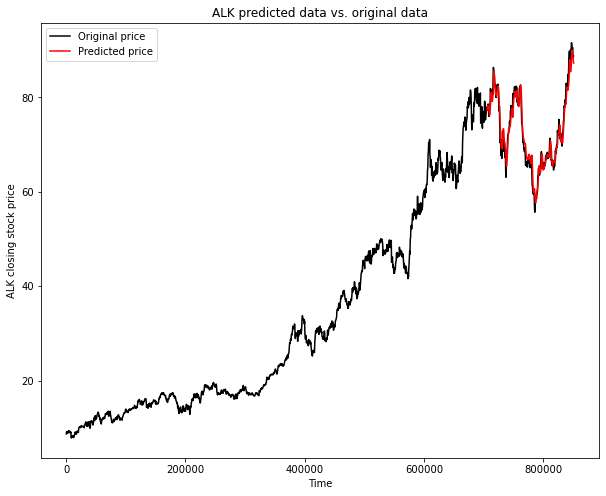

In [30]:
ALK_oriplot = ALK
ALK_predictplot = ALKtest[50:]
ALK_predictplot['predict'] = ALK_predict

plt.plot(ALK_oriplot['close'],'k')
plt.plot(ALK_predictplot['predict'], 'r')
plt.title('ALK predicted data vs. original data')
plt.xlabel('Time')
plt.ylabel('ALK closing stock price')
plt.legend(['Original price',  'Predicted price'])
plt.show()

**DAL**

In [31]:
#convert into timeseries
DALtrain_x=[]
DALtrain_y=[]
for i in range(50,len(DALtrain_data)):
    DALtrain_x.append(DALtrain_data[i-50:i,0])
    DALtrain_y.append(DALtrain_data[i,0])
DALtrain_x=np.array(DALtrain_x)
DALtrain_y=np.array(DALtrain_y)
#reshape data to(samples, features, time stemps)
DALtrain_x = DALtrain_x.reshape(DALtrain_x.shape[0],DALtrain_x.shape[1],1)

DALtest_x = []
DALtest_y = DALtest_data[50:]
for i in range(50,len(DALtest_data)):
    DALtest_x.append(DALtest_data[i-50:i,0])
DALtest_x = np.array(DALtest_x)
#reshape data to(samples, features, time stemps)
DALtest_x = DALtest_x.reshape(DALtest_x.shape[0],DALtest_x.shape[1],1)

In [32]:
#define LSTM model
model = Sequential()
#80 LSTM units
model.add(LSTM(80,input_shape=(DALtrain_x.shape[1],1), return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=False))
#add Dense layer, output 1 dimension
model.add(Dense(1))
#evaluating based on mean square error (mse), use adadelta to optimize
model.compile(loss='mse',optimizer='adam')

In [33]:
#train model
#10-fold cross validation 
#batch_size=20, epochs=50
%time model.fit(DALtrain_x, DALtrain_y,validation_split=0.1,batch_size=20, epochs=50)
#predict
%time DAL_predict = model.predict(DALtest_x) 
#denormalize
DAL_predict = scaler.inverse_transform(DAL_predict)
#mse on train dataset and test dataset
DAL_train_mse = model.evaluate(DALtrain_x, DALtrain_y, verbose=0)
DAL_test_mse = model.evaluate(DALtest_x, DALtest_y, verbose=0)
print('mse on train dataset = '"%.7f" % DAL_train_mse,
      'mse on test dataset = '"%.7f" % DAL_test_mse)

Epoch 1/50
62/62 [==============================] - 4s 66ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 2/50
62/62 [==============================] - 3s 44ms/step - loss: 2.6559e-04 - val_loss: 6.4642e-04
Epoch 3/50
62/62 [==============================] - 3s 44ms/step - loss: 2.9650e-04 - val_loss: 7.1928e-04
Epoch 4/50
62/62 [==============================] - 3s 44ms/step - loss: 2.7258e-04 - val_loss: 0.0017
Epoch 5/50
62/62 [==============================] - 3s 44ms/step - loss: 2.3911e-04 - val_loss: 5.6047e-04
Epoch 6/50
62/62 [==============================] - ETA: 0s - loss: 2.6547e-04- ETA: 0s - loss: - 3s 43ms/step - loss: 2.6547e-04 - val_loss: 5.5421e-04
Epoch 7/50
62/62 [==============================] - ETA: 0s - loss: 2.2324e-0 - 3s 43ms/step - loss: 2.2324e-04 - val_loss: 6.6786e-04
Epoch 8/50
62/62 [==============================] - 3s 43ms/step - loss: 2.4220e-04 - val_loss: 0.0020
Epoch 9/50
62/62 [==============================] - 3s 43ms/step - loss: 3.1703e-04 - 

<ipython-input-34-f6fba5849b76>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DAL_predictplot['predict'] = DAL_predict


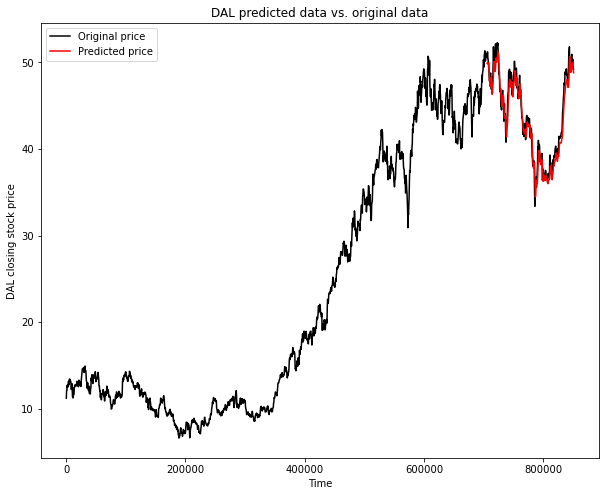

In [34]:
#comparison plot
DAL_oriplot = DAL
DAL_predictplot = DALtest[50:]
DAL_predictplot['predict'] = DAL_predict

plt.plot(DAL_oriplot['close'],'k')
plt.plot(DAL_predictplot['predict'], 'r')
plt.title('DAL predicted data vs. original data')
plt.xlabel('Time')
plt.ylabel('DAL closing stock price')
plt.legend(['Original price',  'Predicted price'])
plt.show()

**UAL**

In [35]:
#convert into timeseries
UALtrain_x=[]
UALtrain_y=[]
for i in range(50,len(UALtrain_data)):
    UALtrain_x.append(UALtrain_data[i-50:i,0])
    UALtrain_y.append(UALtrain_data[i,0])
UALtrain_x=np.array(UALtrain_x)
UALtrain_y=np.array(UALtrain_y)
#reshape data to(samples, features, time stemps)
UALtrain_x = UALtrain_x.reshape(UALtrain_x.shape[0],UALtrain_x.shape[1],1)

UALtest_x = []
UALtest_y = UALtest_data[50:]
for i in range(50,len(UALtest_data)):
    UALtest_x.append(UALtest_data[i-50:i,0])
UALtest_x = np.array(UALtest_x)
#reshape data to(samples, features, time stemps)
UALtest_x = UALtest_x.reshape(UALtest_x.shape[0],UALtest_x.shape[1],1)

In [36]:
#define LSTM model
model = Sequential()
#80 LSTM units
model.add(LSTM(80,input_shape=(UALtrain_x.shape[1],1), return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=False))
#add Dense layer, output 1 dimension
model.add(Dense(1))
#evaluating based on mean square error (mse), use adadelta to optimize
model.compile(loss='mse',optimizer='adam')

In [37]:
#train model
#10-fold cross validation 
#batch_size=20, epochs=50
%time model.fit(UALtrain_x, UALtrain_y,validation_split=0.1,batch_size=20, epochs=50)
#predict
%time UAL_predict = model.predict(UALtest_x) 
#denormalize
UAL_predict = scaler.inverse_transform(UAL_predict)
#mse on train dataset and test dataset
UAL_train_mse = model.evaluate(UALtrain_x, UALtrain_y, verbose=0)
UAL_test_mse = model.evaluate(UALtest_x, UALtest_y, verbose=0)
print('mse on train dataset = '"%.7f" % UAL_train_mse,
      'mse on test dataset = '"%.7f" % UAL_test_mse)

Epoch 1/50
62/62 [==============================] - 5s 76ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 2/50
62/62 [==============================] - 3s 47ms/step - loss: 7.5588e-04 - val_loss: 0.0014
Epoch 3/50
62/62 [==============================] - 3s 46ms/step - loss: 8.6062e-04 - val_loss: 0.0034
Epoch 4/50
62/62 [==============================] - 3s 45ms/step - loss: 7.9128e-04 - val_loss: 0.0020
Epoch 5/50
62/62 [==============================] - 3s 48ms/step - loss: 7.0589e-04 - val_loss: 0.0027
Epoch 6/50
62/62 [==============================] - 3s 45ms/step - loss: 6.8045e-04 - val_loss: 0.0020
Epoch 7/50
62/62 [==============================] - 3s 46ms/step - loss: 5.9975e-04 - val_loss: 0.0016
Epoch 8/50
62/62 [==============================] - 3s 47ms/step - loss: 6.4144e-04 - val_loss: 0.0010
Epoch 9/50
62/62 [==============================] - 3s 46ms/step - loss: 6.1531e-04 - val_loss: 9.8030e-04
Epoch 10/50
62/62 [==============================] - 3s 48ms/step - loss:

<ipython-input-38-13a85ad87c38>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UAL_predictplot['predict'] = UAL_predict


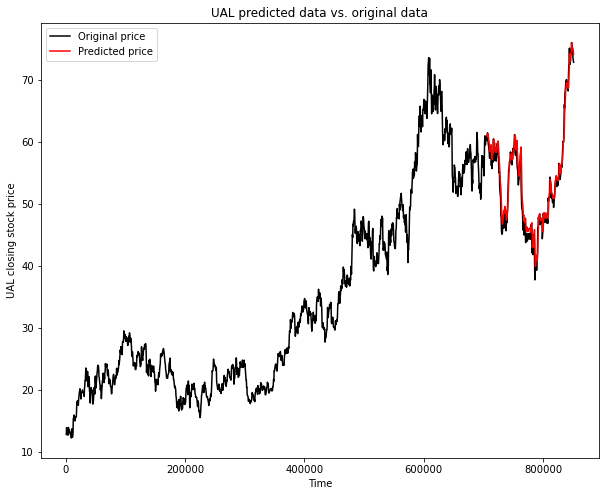

In [38]:
#comparison plot
UAL_oriplot = UAL
UAL_predictplot = UALtest[50:]
UAL_predictplot['predict'] = UAL_predict

plt.plot(UAL_oriplot['close'],'k')
plt.plot(UAL_predictplot['predict'], 'r')
plt.title('UAL predicted data vs. original data')
plt.xlabel('Time')
plt.ylabel('UAL closing stock price')
plt.legend(['Original price',  'Predicted price'])
plt.show()

**LUV**

In [39]:
#convert into timeseries
LUVtrain_x=[]
LUVtrain_y=[]
for i in range(50,len(LUVtrain_data)):
    LUVtrain_x.append(LUVtrain_data[i-50:i,0])
    LUVtrain_y.append(LUVtrain_data[i,0])
LUVtrain_x=np.array(LUVtrain_x)
LUVtrain_y=np.array(LUVtrain_y)
#reshape data to(samples, features, time stemps)
LUVtrain_x = LUVtrain_x.reshape(LUVtrain_x.shape[0],LUVtrain_x.shape[1],1)

LUVtest_x = []
LUVtest_y = LUVtest_data[50:]
for i in range(50,len(LUVtest_data)):
    LUVtest_x.append(LUVtest_data[i-50:i,0])
LUVtest_x = np.array(LUVtest_x)
#reshape data to(samples, features, time stemps)
LUVtest_x = LUVtest_x.reshape(LUVtest_x.shape[0],LUVtest_x.shape[1],1)

In [40]:
#define LSTM model
model = Sequential()
#80 LSTM units
model.add(LSTM(80,input_shape=(LUVtrain_x.shape[1],1), return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=False))
#add Dense layer, output 1 dimension
model.add(Dense(1))
#evaluating based on mean square error (mse), use adadelta to optimize
model.compile(loss='mse',optimizer='adam')

In [41]:
#train model
#10-fold cross validation 
#batch_size=20, epochs=50
%time model.fit(LUVtrain_x, LUVtrain_y,validation_split=0.1,batch_size=20, epochs=50)
#predict
%time LUV_predict = model.predict(LUVtest_x) 
#denormalize
LUV_predict = scaler.inverse_transform(LUV_predict)
#mse on train dataset and test dataset
LUV_train_mse = model.evaluate(LUVtrain_x, LUVtrain_y, verbose=0)
LUV_test_mse = model.evaluate(LUVtest_x, LUVtest_y, verbose=0)
print('mse on train dataset = '"%.7f" % LUV_train_mse,
      'mse on test dataset = '"%.7f" % LUV_test_mse)

Epoch 1/50
62/62 [==============================] - 4s 67ms/step - loss: 0.0014 - val_loss: 5.9144e-04
Epoch 2/50
62/62 [==============================] - 3s 45ms/step - loss: 1.3417e-04 - val_loss: 8.1836e-04 ETA: 0s - loss
Epoch 3/50
62/62 [==============================] - 3s 45ms/step - loss: 1.2871e-04 - val_loss: 6.3029e-041.2369e
Epoch 4/50
62/62 [==============================] - 3s 45ms/step - loss: 1.3464e-04 - val_loss: 6.1804e-04
Epoch 5/50
62/62 [==============================] - 3s 46ms/step - loss: 2.0799e-04 - val_loss: 8.9478e-04ss: 2.1166e-
Epoch 6/50
62/62 [==============================] - 3s 45ms/step - loss: 1.9676e-04 - val_loss: 0.0032
Epoch 7/50
62/62 [==============================] - 3s 45ms/step - loss: 1.5489e-04 - val_loss: 6.4335e-04
Epoch 8/50
62/62 [==============================] - 3s 45ms/step - loss: 1.1276e-04 - val_loss: 4.0364e-04
Epoch 9/50
62/62 [==============================] - 3s 45ms/step - loss: 1.8694e-04 - val_loss: 0.0015
Epoch 10/50
62/

<ipython-input-42-d65d2024f454>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LUV_predictplot['predict'] = LUV_predict


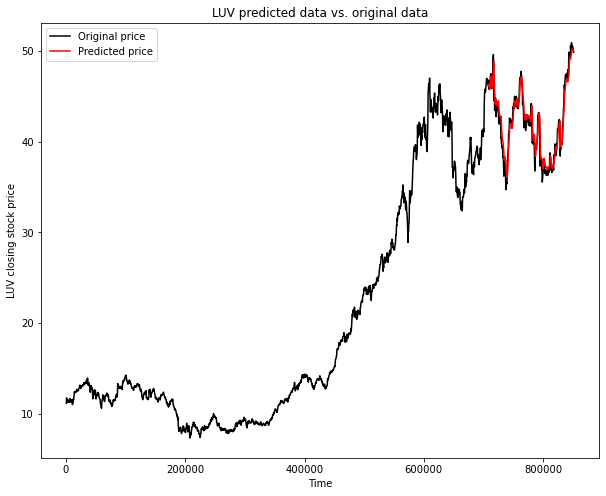

In [42]:
#comparison plot
LUV_oriplot = LUV
LUV_predictplot = LUVtest[50:]
LUV_predictplot['predict'] = LUV_predict

plt.plot(LUV_oriplot['close'],'k')
plt.plot(LUV_predictplot['predict'], 'r')
plt.title('LUV predicted data vs. original data')
plt.xlabel('Time')
plt.ylabel('LUV closing stock price')
plt.legend(['Original price',  'Predicted price'])
plt.show()

**AAL**

In [43]:
#convert into timeseries
AALtrain_x=[]
AALtrain_y=[]
for i in range(50,len(AALtrain_data)):
    AALtrain_x.append(AALtrain_data[i-50:i,0])
    AALtrain_y.append(AALtrain_data[i,0])
AALtrain_x=np.array(AALtrain_x)
AALtrain_y=np.array(AALtrain_y)
#reshape data to(samples, features, time stemps)
AALtrain_x = AALtrain_x.reshape(AALtrain_x.shape[0],AALtrain_x.shape[1],1)

AALtest_x = []
AALtest_y = AALtest_data[50:]
for i in range(50,len(AALtest_data)):
    AALtest_x.append(AALtest_data[i-50:i,0])
AALtest_x = np.array(AALtest_x)
#reshape data to(samples, features, time stemps)
AALtest_x = AALtest_x.reshape(AALtest_x.shape[0],AALtest_x.shape[1],1)

In [44]:
#define LSTM model
model = Sequential()
#80 LSTM units
model.add(LSTM(80,input_shape=(AALtrain_x.shape[1],1), return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=False))
#add Dense layer, output 1 dimension
model.add(Dense(1))
#evaluating based on mean square error (mse), use adadelta to optimize
model.compile(loss='mse',optimizer='adam')

In [45]:
#train model
#10-fold cross validation 
#batch_size=20, epochs=50
%time model.fit(AALtrain_x, AALtrain_y,validation_split=0.1,batch_size=20, epochs=50)
#predict
%time AAL_predict = model.predict(AALtest_x) 
#denormalize
AAL_predict = scaler.inverse_transform(AAL_predict)
#mse on train dataset and test dataset
AAL_train_mse = model.evaluate(AALtrain_x, AALtrain_y, verbose=0)
AAL_test_mse = model.evaluate(AALtest_x, AALtest_y, verbose=0)
print('mse on train dataset = '"%.7f" % AAL_train_mse,
      'mse on test dataset = '"%.7f" % AAL_test_mse)

Epoch 1/50
62/62 [==============================] - 6s 90ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 2/50
62/62 [==============================] - 3s 55ms/step - loss: 4.3675e-04 - val_loss: 0.0010
Epoch 3/50
62/62 [==============================] - 4s 57ms/step - loss: 3.8602e-04 - val_loss: 0.0021
Epoch 4/50
62/62 [==============================] - 4s 57ms/step - loss: 3.4165e-04 - val_loss: 0.0011
Epoch 5/50
62/62 [==============================] - 3s 55ms/step - loss: 3.1738e-04 - val_loss: 0.0010
Epoch 6/50
62/62 [==============================] - 3s 55ms/step - loss: 3.2610e-04 - val_loss: 0.0011
Epoch 7/50
62/62 [==============================] - 3s 55ms/step - loss: 3.9416e-04 - val_loss: 0.0013
Epoch 8/50
62/62 [==============================] - 3s 56ms/step - loss: 2.9021e-04 - val_loss: 9.9474e-04
Epoch 9/50
62/62 [==============================] - 3s 55ms/step - loss: 3.3658e-04 - val_loss: 9.0025e-04
Epoch 10/50
62/62 [==============================] - 3s 52ms/step - l

<ipython-input-46-8f63b463468c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAL_predictplot['predict'] = AAL_predict


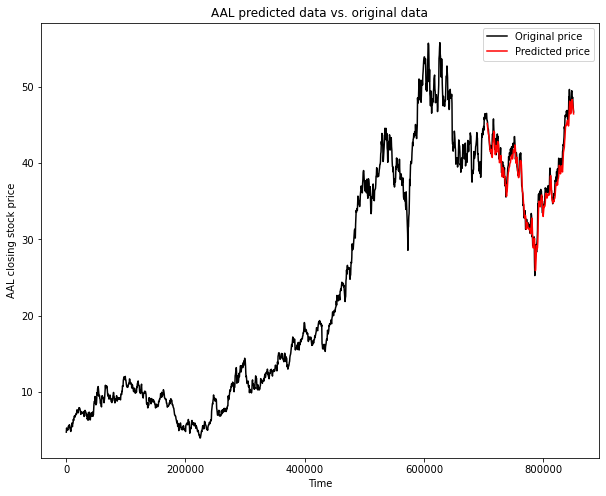

In [46]:
#comparison plot
AAL_oriplot = AAL
AAL_predictplot = AALtest[50:]
AAL_predictplot['predict'] = AAL_predict

plt.plot(AAL_oriplot['close'],'k')
plt.plot(AAL_predictplot['predict'], 'r')
plt.title('AAL predicted data vs. original data')
plt.xlabel('Time')
plt.ylabel('AAL closing stock price')
plt.legend(['Original price',  'Predicted price'])
plt.show()

*Comparison of optimizers*

In [ ]:
#compare the Mean Squared Error (MSE) of the models optimized by Adadelta, Adagrad and Adam, and chose Adam which had better performance. 
'''
#Adadelta
#define LSTM model
model = Sequential()
#80 LSTM units
model.add(LSTM(80,input_shape=(AALtrain_x.shape[1],1), return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=False))
#add Dense layer, output 1 dimension
model.add(Dense(1))
#evaluating based on mean square error (mse), use adadelta to optimize
model.compile(loss='mse',optimizer='Adadelta')

#train model
#10-fold cross validation 
#batch_size=20, epochs=50
model.fit(AALtrain_x, AALtrain_y,validation_split=0.1,batch_size=20, epochs=50)
#predict
AAL_predict = model.predict(AALtest_x) 
#denormalize
AAL_predict = scaler.inverse_transform(AAL_predict)
#mse on train dataset and test dataset
AAL_train_mse = model.evaluate(AALtrain_x, AALtrain_y, verbose=0)
AAL_test_mse = model.evaluate(AALtest_x, AALtest_y, verbose=0)
print('mse on train dataset = '"%.7f" % AAL_train_mse,
      'mse on test dataset = '"%.7f" % AAL_test_mse)
'''
'''
#Adagrad
#define LSTM model
model = Sequential()
#80 LSTM units
model.add(LSTM(80,input_shape=(AALtrain_x.shape[1],1), return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=False))
#add Dense layer, output 1 dimension
model.add(Dense(1))
#evaluating based on mean square error (mse), use adadelta to optimize
model.compile(loss='mse',optimizer='Adagrad') 

#train model
#10-fold cross validation 
#batch_size=20, epochs=50
model.fit(AALtrain_x, AALtrain_y,validation_split=0.1,batch_size=20, epochs=50)
#predict
AAL_predict = model.predict(AALtest_x) 
#denormalize
AAL_predict = scaler.inverse_transform(AAL_predict)
#mse on train dataset and test dataset
AAL_train_mse = model.evaluate(AALtrain_x, AALtrain_y, verbose=0)
AAL_test_mse = model.evaluate(AALtest_x, AALtest_y, verbose=0)
print('mse on train dataset = '"%.7f" % AAL_train_mse,
      'mse on test dataset = '"%.7f" % AAL_test_mse)
'''